<a href="https://colab.research.google.com/github/icezyf/data_projects/blob/main/Spark_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommendation in Spark** #
In this notebook, an Alternating Least Squares (ALS) algorithm with Spark APIs would be applied to predict the ratings for the movies in [MovieLens Small Dataset](https://grouplens.org/datasets/movielens/latest/)


*Analyzed by Crystella Yufei Zheng*

### **0. Data ETL and Data Exploration** ###

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
# Miscellaneous operating system interfaces
import os 
# os.environ: A mapping object representing the string environment. 
# behaves like a python dictionary, so all the common dictionary operations like get 
# and set can be performed. 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
# Provides findspark.init() to make pyspark importable as a regular library.
findspark.init() 
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!ls

sample_data  spark-3.1.2-bin-hadoop3.2	spark-3.1.2-bin-hadoop3.2.tgz


In [ ]:
spark.version

'3.1.2'

In [ ]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
 
os.environ["PYSPARK_PYTHON"] = "python3"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data  spark-3.1.2-bin-hadoop3.2  spark-3.1.2-bin-hadoop3.2.tgz


In [ ]:
link_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Data/ml-latest-small/links.csv", format='csv', header = True)
movie_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Data/ml-latest-small/movies.csv", format='csv', header = True)
rating_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Data/ml-latest-small/ratings.csv", format='csv', header = True)
tag_df = spark.read.load("/content/drive/MyDrive/Colab Notebooks/Data/ml-latest-small/tags.csv", format='csv', header = True)

In [ ]:
movie_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
rating_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
link_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [ ]:
tag_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [ ]:
tmp1 = rating_df.groupBy("userId").count().toPandas()['count'].min()
tmp2 = rating_df.groupBy("movieId").count().toPandas()['count'].min()
tmp3 = rating_df.groupBy("movieId").count().where('count=1').count()
tmp4 = rating_df.select('movieId').distinct().count()

print(f'''For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is {tmp1}.
Minimum number of ratings per movie is {tmp2}.
{tmp3} out of {tmp4} movies are rated by only one user.''')

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20.
Minimum number of ratings per movie is 1.
3446 out of 9724 movies are rated by only one user.


In [ ]:
# change the type of rating into float, the type of userID and movieId into interger
rating_pd = rating_df.toPandas()
rating_pd['movieId'] = rating_pd['movieId'].astype('int64')
rating_pd['userId'] = rating_pd['userId'].astype('int64')
rating_pd['rating'] = rating_pd['rating'].astype('float64')
rating_pd = rating_pd.drop(['timestamp'], axis=1)
rating_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [ ]:
# calculate the size of ratings matrix
mov_cnt = rating_pd['movieId'].drop_duplicates().count()
user_cnt = rating_pd['userId'].drop_duplicates().count()
rate_cnt = rating_pd['rating'].count()
matrix_size = user_cnt * mov_cnt
percentage = rate_cnt/matrix_size * 100
print(f'''
From the ratings file, we obtained the info of ratings matrix as below:
total movies are: {mov_cnt}
total users are: {user_cnt}
total ratings are: {rate_cnt}
maxtrix size is {matrix_size}
{percentage.round()}% of the matrix is filled.
''')


From the ratings file, we obtained the info of ratings matrix as below:
total movies are: 9724
total users are: 610
total ratings are: 100836
maxtrix size is 5931640
2.0% of the matrix is filled.



In [ ]:
movie_df.registerTempTable("movie")
rating_df.registerTempTable("rating")
link_df.registerTempTable("link")
tag_df.registerTempTable("tag")

### **1. OLAP** ### 

#### **1.1 The Numbers of Users and Movies** ####

In [ ]:
user_cnt = spark.sql('select count(distinct userId) as Number_of_Users ' +\
                     'from rating').toPandas()
user_cnt

,Number_of_Users
0,610


In [ ]:
mov_cnt = spark.sql('select count(distinct movieId) as Movie_Count ' +\
                    'from movie').toPandas()
mov_cnt

,Movie_Count
0,9742


#### **1.2 How many movies are rated by users? List movies not rated before** ####

In [ ]:
rated_cnt = spark.sql('select count(distinct movieId) as Num_of_Rated_Movie ' +\
                      'from movie ' +\
                      'where movieId in (select movieId from rating)').toPandas()
rated_cnt

,Num_of_Rated_Movie
0,9724


In [ ]:
unrated_mov = spark.sql('select * ' +\
                        'from movie ' +\
                        'where movieId not in (select movieId from rating)').toPandas()
unrated_mov

,movieId,title,genres
0,1076,"Innocents, The (1961)",Drama|Horror|Thriller
1,2939,Niagara (1953),Drama|Thriller
2,3338,For All Mankind (1989),Documentary
3,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
4,4194,I Know Where I'm Going! (1945),Drama|Romance|War
5,5721,"Chosen, The (1981)",Drama
6,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
7,6849,Scrooge (1970),Drama|Fantasy|Musical
8,7020,Proof (1991),Comedy|Drama|Romance
9,7792,"Parallax View, The (1974)",Thriller


#### **1.3 List Movie Genres** ####

In [ ]:
genre_df = spark.sql("select distinct explode(split(genres, '[|]')) as Genres " +\
                     "from movie " +\
                     "order by 1").toPandas()
genre_df

,Genres
0,(no genres listed)
1,Action
2,Adventure
3,Animation
4,Children
5,Comedy
6,Crime
7,Documentary
8,Drama
9,Fantasy


#### **1.4 Movie for Each Category** ####

In [ ]:
mov_per_cat = spark.sql("select Genres, count(movieId) as Num_of_Movies " +\
                        "from (select distinct explode(split(genres, '[|]')) as Genres, movieId from movie) " +\
                        "group by 1 " +\
                        "order by 2 desc").toPandas()
mov_per_cat

,Genres,Num_of_Movies
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779


In [ ]:
mov_lst = spark.sql("select Genres, concat_ws(',', collect_set(title)) as Movie_List " +\
                    "from (select distinct explode(split(genres, '[|]')) as Genres, title from movie)" +\
                    "group by 1").toPandas()
mov_lst

,Genres,Movie_List
0,Crime,"Stealing Rembrandt (Rembrandt) (2003),The Gamb..."
1,Romance,"Vampire in Brooklyn (1995),Hysteria (2011),Far..."
2,Thriller,"Element of Crime, The (Forbrydelsens Element) ..."
3,Adventure,"Ice Age: Collision Course (2016),Masters of th..."
4,Drama,"Airport '77 (1977),Element of Crime, The (Forb..."
5,War,"General, The (1926),Joyeux Noël (Merry Christm..."
6,Documentary,"Jim & Andy: The Great Beyond (2017),U2: Rattle..."
7,Fantasy,"Masters of the Universe (1987),Odd Life of Tim..."
8,Mystery,"Before and After (1996),Primal Fear (1996),'Sa..."
9,Musical,"U2: Rattle and Hum (1988),Sword in the Stone, ..."


#### **1.5 Which rate did the majority users prefer? (optional)** ####

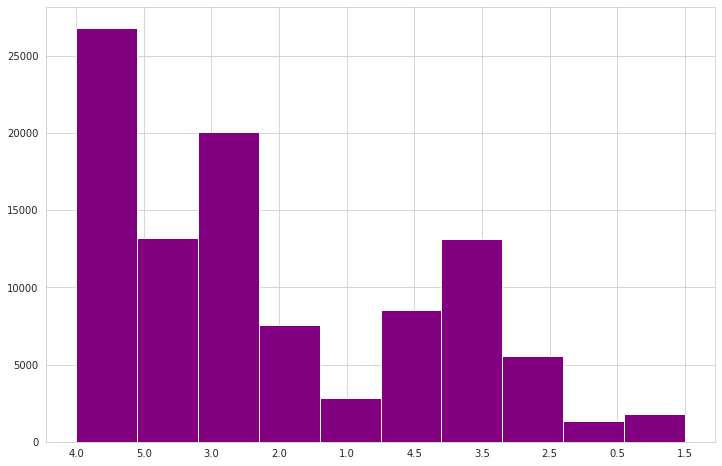

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
rating_pd_graph = rating_df.toPandas()
plt.hist(rating_pd_graph.rating, color='purple')
display()

#### **1.6 What are the top 20 movies that are rated most? (optional)** ####

In [ ]:
most_rated = spark.sql('select a.movieId, a.title, count(rating) as rating_cnt from movie a join rating b on a.movieId = b.movieId group by 1, 2 order by 3 desc limit 20')
most_rated.show()

+-------+--------------------+----------+
|movieId|               title|rating_cnt|
+-------+--------------------+----------+
|    356| Forrest Gump (1994)|       329|
|    318|Shawshank Redempt...|       317|
|    296| Pulp Fiction (1994)|       307|
|    593|Silence of the La...|       279|
|   2571|  Matrix, The (1999)|       278|
|    260|Star Wars: Episod...|       251|
|    480|Jurassic Park (1993)|       238|
|    110|   Braveheart (1995)|       237|
|    589|Terminator 2: Jud...|       224|
|    527|Schindler's List ...|       220|
|   2959|   Fight Club (1999)|       218|
|      1|    Toy Story (1995)|       215|
|   1196|Star Wars: Episod...|       211|
|   2858|American Beauty (...|       204|
|     50|Usual Suspects, T...|       204|
|     47|Seven (a.k.a. Se7...|       203|
|    780|Independence Day ...|       202|
|    150|    Apollo 13 (1995)|       201|
|   1198|Raiders of the Lo...|       200|
|   4993|Lord of the Rings...|       198|
+-------+--------------------+----

### **2. Spark ALS based approach for training model** ### 
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [ ]:
rating_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
#drop unnecessary column 
rating_ndf =rating_df.drop('timestamp')

#convert types to desired ones by pyspark dataframe formats
from pyspark.sql.types import IntegerType, FloatType
rating_ndf = rating_ndf.withColumn("userId", rating_ndf["userId"].cast(IntegerType()))
rating_ndf = rating_ndf.withColumn("movieId", rating_ndf["movieId"].cast(IntegerType()))
rating_ndf = rating_ndf.withColumn("rating", rating_ndf["rating"].cast(FloatType()))
rating_ndf.show()
rating_ndf.printSchema()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



#### **2.1 ALS Model Selection and Evaluation** ####
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [ ]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
# create test and train set
(training, test) = rating_ndf.randomSplit([0.8,0.2])

In [ ]:
# create ALS model
# set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
from pyspark.ml.recommendation import ALS
als = ALS(maxIter=10, rank=10, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy="drop")

In [ ]:
# tune model using ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(als.regParam, [0.05, 0.1, 0.3, 0.5])
             .addGrid(als.rank, [5, 10, 15])
             .addGrid(als.maxIter, [1, 5, 10])
             .build())

In [ ]:
# define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [ ]:
# build Cross validation 
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [ ]:
# fit ALS model to training data
cvModel = cv.fit(training)

In [ ]:
# extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

#### **2.2 Model Testing** ####
Finally, make a prediction and check the testing error.

In [ ]:
# generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
# print evaluation metrics and model parameters
print("RMSE =" + str(rmse))
print(" ** Best Model** ")
print(" Rank = " + str(bestModel._java_obj.parent().getRank()))
print(" MaxIter =" + str(bestModel._java_obj.parent().getMaxIter()))
print(" RegParam = " + str(bestModel._java_obj.parent().getRegParam()))

RMSE =0.8812061645142741
 ** Best Model** 
 Rank = 5
 MaxIter =10
 RegParam = 0.1


In [ ]:
predictions.toPandas()

,userId,movieId,rating,prediction
0,409,471,3.0,4.198646
1,372,471,3.0,3.443952
2,599,471,2.5,2.531919
3,603,471,4.0,3.164718
4,218,471,4.0,2.371195
...,...,...,...,...
19523,249,79008,4.5,4.036290
19524,563,84374,2.5,3.332607
19525,298,84374,0.5,1.600757
19526,562,84374,3.5,3.266908


#### **2.3 Model Apply and Check the Performance** ####

In [ ]:
alldata = bestModel.transform(rating_ndf)
rmse = evaluator.evaluate(alldata)
print("RMSE (for whole dataset) = " + str(rmse))

RMSE (for whole dataset) = 0.6927761542800891


In [ ]:
alldata.registerTempTable('alldata_view')
alldata.toPandas()

,userId,movieId,rating,prediction
0,191,148,5.0,4.933486
1,133,471,4.0,3.162882
2,597,471,2.0,4.087759
3,385,471,4.0,3.312406
4,436,471,3.0,3.612757
...,...,...,...,...
100057,567,145839,1.5,1.477010
100058,210,147378,4.5,4.061054
100059,380,147378,3.0,3.143582
100060,525,147378,3.5,2.670312


In [ ]:
mov_rating_df = spark.sql('select b.*, a.title, a.genres ' +\
                          'from movie a join alldata_view b on a.movieId=b.movieId')
mov_rating_df.toPandas()

,userId,movieId,rating,prediction,title,genres
0,191,148,5.0,4.933486,"Awfully Big Adventure, An (1995)",Drama
1,133,471,4.0,3.162882,"Hudsucker Proxy, The (1994)",Comedy
2,597,471,2.0,4.087759,"Hudsucker Proxy, The (1994)",Comedy
3,385,471,4.0,3.312406,"Hudsucker Proxy, The (1994)",Comedy
4,436,471,3.0,3.612757,"Hudsucker Proxy, The (1994)",Comedy
...,...,...,...,...,...,...
100057,567,145839,1.5,1.477010,Concussion (2015),Drama
100058,210,147378,4.5,4.061054,Doctor Who: Planet of the Dead (2009),Adventure|Children|Drama|Sci-Fi
100059,380,147378,3.0,3.143582,Doctor Who: Planet of the Dead (2009),Adventure|Children|Drama|Sci-Fi
100060,525,147378,3.5,2.670312,Doctor Who: Planet of the Dead (2009),Adventure|Children|Drama|Sci-Fi


### **3. Make Recommendations** ###
Find the similar moives based on the ALS results

#### **3.1 Find the similar moives for users with id: 575， 232** ####

- Method 1: create a function to wrap up model, user and quantity of recommended movies



In [ ]:
from pyspark.sql.functions import lit
#lit: Creates a Column of literal value

def userRecs1(model, user, quantity):
    # the specified user and all the movies listed in the ratings
    userSet = mov_rating_df.select('movieId').distinct().withColumn('userId', lit(user))
    
    # the movies that have already been rated by this user
    ratedSet = mov_rating_df.filter(mov_rating_df.userId == user).select('movieId', 'userId')
    
    # apply the recommender system to the dataset without the already-rated movies to predict ratings
    predictions = model.transform(userSet.subtract(ratedSet)).dropna().orderBy('prediction', ascending=False).limit(quantity).select('movieId', 'prediction')
    
    # Join with the movies_df to get the movies titles and genres
    recommendations = predictions.join(movie_df, predictions.movieId == movie_df.movieId).select(predictions.movieId, movie_df.title, movie_df.genres, predictions.prediction)
    return recommendations

In [ ]:
userRecs1(bestModel, 575, 10).toPandas()

,movieId,title,genres,prediction
0,441,Dazed and Confused (1993),Comedy,5.032527
1,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama,5.052160
2,5075,Waydowntown (2000),Comedy,5.179841
3,6086,"I, the Jury (1982)",Crime|Drama|Thriller,5.087701
4,7096,Rivers and Tides (2001),Documentary,5.098831
5,7841,Children of Dune (2003),Fantasy|Sci-Fi,5.476450
6,33649,Saving Face (2004),Comedy|Drama|Romance,5.124772
7,58303,"Counterfeiters, The (Die Fälscher) (2007)",Crime|Drama|War,5.169242
8,59018,"Visitor, The (2007)",Drama|Romance,5.411258
9,60943,Frozen River (2008),Drama,5.411258


In [ ]:
userRecs1(bestModel, 232, 10).toPandas()

,movieId,title,genres,prediction
0,7071,"Woman Under the Influence, A (1974)",Drama,4.631033
1,26073,"Human Condition III, The (Ningen no joken III)...",Drama|War,4.631033
2,26928,"Summer's Tale, A (Conte d'été) (1996)",Comedy|Drama|Romance,4.631033
3,33649,Saving Face (2004),Comedy|Drama|Romance,4.880827
4,74226,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",Documentary|Drama,4.631033
5,84273,Zeitgeist: Moving Forward (2011),Documentary,4.631033
6,86237,Connections (1978),Documentary,4.631033
7,93988,North & South (2004),Drama|Romance,4.656671
8,134796,Bitter Lake (2015),Documentary,4.631033
9,138966,Nasu: Summer in Andalusia (2003),Animation,4.631033


- Method 2: recommend by ALS api "recommendForAllUsers()"

In [ ]:
userRecs2 = bestModel.recommendForAllUsers(10)
userRecs2.toPandas()

,userId,recommendations
0,471,"[(89904, 4.959934711456299), (8235, 4.86559104..."
1,463,"[(6818, 5.416696071624756), (33649, 5.38040208..."
2,496,"[(6818, 5.079161167144775), (3266, 4.965522766..."
3,148,"[(49347, 4.969733715057373), (51931, 4.9583921..."
4,540,"[(6818, 5.956073760986328), (25771, 5.59065532..."
...,...,...
605,208,"[(6818, 4.963436603546143), (25771, 4.94961690..."
606,401,"[(5666, 4.849633693695068), (1046, 4.500442028..."
607,422,"[(6818, 4.9726176261901855), (33649, 4.7847967..."
608,517,"[(32892, 4.854342460632324), (3283, 4.37140750..."


In [ ]:
from pyspark.sql.functions import explode, col
userRecs2 = userRecs2\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))
userRecs2.toPandas()

,userId,movieId,rating
0,471,89904,4.959935
1,471,8235,4.865591
2,471,4495,4.865591
3,471,51931,4.761309
4,471,158966,4.743157
...,...,...,...
6095,89,136341,4.931743
6096,89,53280,4.931743
6097,89,131130,4.931743
6098,89,147410,4.931743


In [ ]:
userRecs2.join(movie_df, on='movieId').filter('userId = 575').toPandas()

,movieId,userId,rating,title,genres
0,7841,575,5.476450,Children of Dune (2003),Fantasy|Sci-Fi
1,59018,575,5.411258,"Visitor, The (2007)",Drama|Romance
2,60943,575,5.411258,Frozen River (2008),Drama
3,5075,575,5.179841,Waydowntown (2000),Comedy
4,58303,575,5.169242,"Counterfeiters, The (Die Fälscher) (2007)",Crime|Drama|War
5,33649,575,5.124772,Saving Face (2004),Comedy|Drama|Romance
6,7096,575,5.098831,Rivers and Tides (2001),Documentary
7,6086,575,5.087701,"I, the Jury (1982)",Crime|Drama|Thriller
8,1237,575,5.052160,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama
9,441,575,5.032527,Dazed and Confused (1993),Comedy


In [ ]:
userRecs2.join(movie_df, on='movieId').filter('userId = 232').toPandas()

,movieId,userId,rating,title,genres
0,33649,232,4.880827,Saving Face (2004),Comedy|Drama|Romance
1,93988,232,4.656671,North & South (2004),Drama|Romance
2,5666,232,4.646063,"Rules of Attraction, The (2002)",Comedy|Drama|Romance|Thriller
3,184245,232,4.631033,De platte jungle (1978),Documentary
4,179135,232,4.631033,Blue Planet II (2017),Documentary
5,138966,232,4.631033,Nasu: Summer in Andalusia (2003),Animation
6,7071,232,4.631033,"Woman Under the Influence, A (1974)",Drama
7,74226,232,4.631033,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",Documentary|Drama
8,84273,232,4.631033,Zeitgeist: Moving Forward (2011),Documentary
9,26073,232,4.631033,"Human Condition III, The (Ningen no joken III)...",Drama|War


#### **3.2 Find the similar moives for moive with id: 471, 40491** ####

In [ ]:
from pyspark.ml.linalg import *
from pyspark.sql.types import * 

In [ ]:
itemFactors = bestModel.itemFactors
itemFactors.printSchema()
itemFactors.show()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[1.2477971, -1.23...|
| 20|[1.2827852, -0.96...|
| 30|[0.6489236, -0.93...|
| 40|[0.9574917, -1.02...|
| 50|[1.6372948, -1.51...|
| 60|[1.2362996, -1.29...|
| 70|[1.208497, -1.227...|
| 80|[1.4761215, -1.12...|
|100|[1.4798532, -0.68...|
|110|[1.4177991, -1.76...|
|140|[1.6373909, -0.87...|
|150|[1.4349048, -1.56...|
|160|[1.2032279, -0.97...|
|170|[1.4931022, -1.06...|
|180|[0.9167522, -1.45...|
|190|[1.6928645, -0.66...|
|210|[1.282163, -1.115...|
|220|[0.91061413, -1.2...|
|230|[1.3890396, -1.43...|
|240|[0.78188866, -0.9...|
+---+--------------------+
only showing top 20 rows



In [ ]:
def similarMovies(inputId):
  #built a DataFrame for similar movie
  similarMovie=pd.DataFrame(columns=('movieId','cosine_similarity'))
  
  # retrieves all elements in a DataFrame(itemFactors) as an array to the driver.
  movieFeat = itemFactors.filter(itemFactors.id == inputId).select('features').collect()
  
  for id, features in itemFactors.collect():
    cs = np.dot(movieFeat, features) / (np.linalg.norm(movieFeat) * np.linalg.norm(features))
    similarMovie=similarMovie.append({'movieId':str(id), 'cosine_similarity':cs}, ignore_index=True)
    similarMovie_cs = similarMovie.sort_values(by=['cosine_similarity'],ascending = False)[1:11]
    joint = similarMovie_cs.merge(movie_df.toPandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
  return joint[['movieId','title','genres']]

In [ ]:
similarMovies(471)

,movieId,title,genres
0,1096,Sophie's Choice (1982),Drama
1,26171,Play Time (a.k.a. Playtime) (1967),Comedy
2,55245,Good Luck Chuck (2007),Comedy|Romance
3,160271,Central Intelligence (2016),Action|Comedy
4,536,"Simple Twist of Fate, A (1994)",Drama
5,4066,I'm Gonna Git You Sucka (1988),Action|Comedy
6,351,"Corrina, Corrina (1994)",Comedy|Drama|Romance
7,3992,Malèna (2000),Drama|Romance|War
8,97168,Marley (2012),Documentary
9,515,"Remains of the Day, The (1993)",Drama|Romance


In [ ]:
similarMovies(40491)

,movieId,title,genres
0,142507,Pawn Sacrifice (2015),Drama
1,72294,"Christmas Carol, A (2009)",Animation|Children|Drama|Fantasy|IMAX
2,40491,"Match Factory Girl, The (Tulitikkutehtaan tytt...",Comedy|Drama
3,102800,Frances Ha (2012),Comedy|Drama
4,101070,Wadjda (2012),Drama
5,108188,Jack Ryan: Shadow Recruit (2014),Action|Drama|Thriller|IMAX
6,8189,Zazie dans le métro (1960),Comedy
7,51573,Meshes of the Afternoon (1943),Fantasy
8,166705,Fences (2016),Drama
9,114396,Cesar Chavez (2014),Drama


### **4. Write the report** ###

#### **Motivations** ####


> The breakeout of Covid-19 revolutionally changed all aspects of lifestyles. Among them, e-commerce and info streaming have been unprecedentedly boosting. Groceories, shopping, leisures, etc online sales and services are becoming essential. The strategies of appealing customers' eyeballs, seizing business opportunies and promoting more products are heavily relying on Rececommendation System. Here, I applied Collaborative Filtering by Alternating Least Squares (ALS) model with explicit data on looking for similarities in Spark ML. It's quite a creative and interesting attempt for movie-rated users to add similarities in their bucketlist.  



##### **Step 1: Data ETL and Data Exploration** #####
> After loading data, I glimpsed every subjects to see content and data types as well as generating sums of items to roughly know the size of workload.
##### **Step 2: OLAP** #####
> From analytical processing, I computed multidimensional varibles to obtain some perspectives.
##### **Step 3: Model Selection** #####
> Having built up an ALS model, I calculated the RMSE of whole dataset without applying any hyperparameters tuning just to evaluate the model.
##### **Step 4: Evaluate the Model** #####
> Splitted ratings dataset between an 80% training data set and a 20% test data set. Then re-run the steps to train the model on the training set, run it on the test set, and evaluate the performance.
##### **Step 5: Improve the Model** #####
> After computing training set in the ALS model, the lower performance than previous one was found. But it was protected against overfitting: it will actually get this level of performance on incoming data. Tuned hyperparemers by 5-fold cross validation, applying the optimal hyperparameters on the best final model.
##### **Step 6: Model Application: Recommend Movies** #####
> To recommend movies for a specific user, created a function that applies the trained model, ALSModel.
##### **Step 7: Model Application: Similary Movies Recommendation** #####
> To find similar movies based on ALS results, compulated 2 dataframes of given movie and all movie data set by cosine similarity; ranked the result by descending and took top 10 movies.


#### **Output and Conclusion** ####
> 1. The best model for ALS has the parameters to be: maxIter=10, regParam=0.1, rank=5. The rooted mean squared error (RMSE) on the testing data is 0.88 and on the whole dataset is 0.69.

> 2. ALS model is versatile because it not only enables to provide recommendations bu also mine latent information, which is the latent variable in matrix factorization. It's helpful in gaining some deeper insights. In this project, this information was used to measure the difference between any two movies so as to find similar movies.



